# Example

A simple example of the presented ABC method for a 2d Gauss.

All necessary functions are described.

In [1]:
import numpy as np
import scipy as scp
import scipy.stats

import matplotlib.pyplot as plt

## Specify model

In [253]:
"""
Example: 2d Gauss distribution
"""

def model(params):
    # returns a "trace" of two values per gauss
    # specify fixed covariance matrix
    cov = np.eye(2)
    cov[0,0] = 0.5
    cov[1,1] = 1
    cov[0,1] =-0.8
    cov[1,0] = cov[0,1]
    # "evaluate" model
    x = scp.stats.multivariate_normal.rvs(params,cov=cov,size=1).T.flatten()
    return x

def model_mult(params_list, batchsize):
    """
    this could be used to parallelize the model run
    ---
    runs the model for each parameterset in params_list batchsize times
    """
    dim_data=2
    nr_traces = len(params_list)
    
    traces = np.zeros((nr_traces, batchsize, dim_data))
    for i in range(nr_traces):
        for j in range(batchsize):
            traces[i,j] = model(params_list[i])
        
    return traces
    
    

"""
produce some data, from which we want to infer the mean parameteres
"""

# specify dimension and number of datapoints
dim_data = 2
ndata = 100

# specify true means
true_mean = np.array([-1,5]) # length of dim_data

# produce data
data = np.zeros((ndata, dim_data))
for i in range(ndata):
    data[i] = model(true_mean)


In [199]:
np.std(data[:,1])

2.039398494953896

(-10, 10)

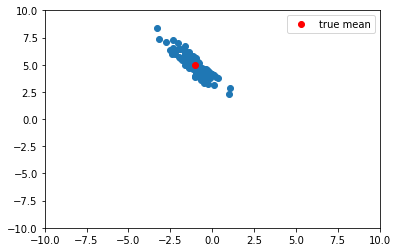

In [254]:
"""
show part of data
"""
plt.plot(data[:,0],data[:,1], 'o')
plt.plot(true_mean[0], true_mean[1],'o', color='r', label='true mean')
plt.legend()
plt.xlim(-10,10)
plt.ylim(-10,10)

## Specify summary statistics and loss function

This is very model specific. There is a lot of literature on how to choose meaningful summary statistics. Including dimensionality reduction of summary statistics and automatic extraction.
See for example "Handbook of Approximate Bayesian Computation" (Sisson, Fan, Beaumont, 2019).

Here we just use the mean of the first and the last two values as summary statistic and a (weighted) pairwise MSE to the observed data as loss function.

In [206]:
"""
summary statistic and loss
"""

def extract_sumstat(traces):
    #sumstats=np.zeros((len(traces),2))
    #for i,trace in enumerate(traces):
    #    sumstats[i] = np.array( [(trace[0]+trace[1])/2, (trace[2]+trace[3])/2])
    #return sumstats
    return traces
    
def loss(traces, sumstat_data, w =[None]):
    """
    should return a ONE dimensional loss value
    ---
    w: optional weighting vector for the different summary statistics. default = 1 for all sumstats.
    """
    
    if w[0]==None:
        w = np.ones(len(sumstat_data[0]))
    
    # extract summary stats for traces
    sumstat_traces = extract_sumstat(traces)
    
    n = len(sumstat_data)
    m = len(sumstat_traces)
    
    # mean of pairwise distance
    MSE_pairwise = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            MSE_pairwise[i,j] = 1/(len(sumstat_data[0]))* np.sum( (sumstat_data[i]-sumstat_traces[j])**2 * w)
                
    return np.mean(MSE_pairwise)




In [255]:
true_mean

array([-1,  5])

In [256]:
# define weightings for loss function
w = np.array([1,1])

# extract summary statistics for data
sumstat_data = extract_sumstat(data)

# evaluate model

params = [-5,10]
ntraces = 50
traces = np.zeros((ntraces, dim_data))
for i in range(ntraces):
    traces[i] = model(params)


print('Loss of true params:',loss(data, sumstat_data, w=w))
print('Loss of some params:',loss(traces, sumstat_data, w=w))

Loss of true params: 1.7678843025042223
Loss of some params: 23.321700665762794


(-10, 20)

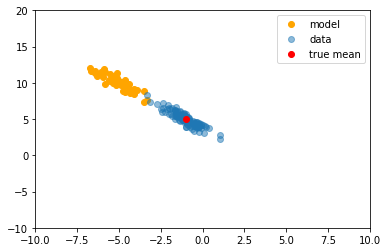

In [258]:
"""
show data and model evaluations
"""
plt.plot(traces[:,0],traces[:,1], 'o', color='orange', label='model')

plt.plot(data[:,0],data[:,1], 'o', label='data', alpha=0.5)

plt.plot(true_mean[0], true_mean[1],'o', color='r', label='true mean')
plt.legend()
plt.xlim(-10,10)
plt.ylim(-10,20)

# Fitting procedure

In [17]:
# import distribution updating and parameter drawing functions
from abc_method import *

### Initializing

In [42]:
true_mean

array([-1,  5])

In [259]:
"""
specify parameters for prior distribution
"""


def makeHypersPrior():
    """
    :return: hyper parameters for the prior distributions
    ---
    the dimension k of the parameter space is indirectly specified here
    """

    prior_means = np.array([0,0])
    lambda0 = np.eye(2)*400 # approximatley cov of prior (param. for Inv-Wishart-distribution)
    
    # parameters for Inv-Wishart should be changed if the dimension k changes
    kappa0 = 4 
    nu0 = 4

    hypers = [prior_means, lambda0, kappa0, nu0]
    
    return hypers


prior_params = makeHypersPrior()

print(prior_params)

[array([0, 0]), array([[400.,   0.],
       [  0., 400.]]), 4, 4]


In [260]:
"""
specify parameters for the fitting procedure
"""

# extract summary statistics for data
sumstat_data = extract_sumstat(data)

verbose = True

## number of samples
# if nr is to small error araises from taking best 1000 values etc.
nSamps0 = 1000 # samples in first round
nSampsLate = 1000 # samples in later rounds

# number of sample to update from (n_accept)
nupdate0 = 10 
nupdate_late = 50 

# number of simulations per parameter draw
batchsize = 3

# number of rounds
rounds = 30

# initialize list to save all hyper paramters
hypersSave = []

# make prior distribution
hypers = makeHypersPrior() 
hypersSave.append(hypers)

for noRun in range(0,rounds):
    if noRun ==0:
        nSamps = nSamps0
        nupdate = nupdate0
    else:
        nSamps = nSampsLate
        nupdate = nupdate_late
    
    if verbose:
        print()
        print('run',noRun)
    
    
    """
    sample parameter
    """
    params = drawSamps(hypers, nSamps)
    if verbose:
        print('finished sampling, now run simulations...')

    
    """
    run the model
    """
    traces = model_mult(params, batchsize)
    
    if verbose:
        print('finished model evaluations.')
        
        
    """
    calculate summary statistics
    """
    loss_params = np.zeros(nSamps)
    for i in range(nSamps):
        loss_params[i] = loss(traces[i], sumstat_data)

    
    """
    sort parameters
    """
    sorted_params = params[loss_params.argsort()]    
    
    if verbose:
        print('mean of accepted parameters:', np.mean(sorted_params[:nupdate], axis=0))
    
    """
    update the hyperparameters
    """
    hypers = makeHypers(hypers, sorted_params, nupdate)
    # save hypers
    hypersSave.append(hypers)
    
    if verbose:
        print('updated hypers:', hypers)
    



run 0
finished sampling, now run simulations...
finished model evaluations.
mean of accepted parameters: [-1.34043525  5.68896847]
updated hypers: [array([-0.95745375,  4.06354891]), array([[406.77085998, -26.36020305],
       [-26.36020305, 505.23975705]]), 14, 14]

run 1
finished sampling, now run simulations...
finished model evaluations.
mean of accepted parameters: [-1.06614706  4.93398707]
updated hypers: [array([-1.0423704 ,  4.74357872]), array([[411.50521044, -25.62068665],
       [-25.62068665, 514.21032427]]), 64, 64]

run 2
finished sampling, now run simulations...
finished model evaluations.
mean of accepted parameters: [-1.17535072  5.0278438 ]
updated hypers: [array([-1.1006951 ,  4.86825638]), array([[415.01938586, -24.49009706],
       [-24.49009706, 518.07030898]]), 114, 114]

run 3
finished sampling, now run simulations...
finished model evaluations.
mean of accepted parameters: [-1.2339595   5.10102713]
updated hypers: [array([-1.14132449,  4.93922307]), array([[41

## some simple plotting

In [278]:
def get_stds(hypers):
    """
    returns std values for one set of hyper params
    """
    k = 2 # dim of parameters
    stds = np.zeros(k)

    for i in range(k):
        stds[i] = (1/(hypers[3] - k) * hypers[1][i,i] )**0.5 #  [muns,Lambdan, kappan, nun]
    
    return stds

def get_cov(hypers):
    """
    expected covs for posterior predictive distribution
    """
    k = 2 
    cov =  hypers[1] * (1/(hypers[3] - k)) 
    return cov

In [279]:
"""
extract values
"""

means = np.zeros(( rounds,2))
covs = np.zeros(( rounds,2,2))
stds = np.zeros(( rounds,2))

for i in range(rounds):
    means[i] = hypersSave[i][0]
    stds[i] = get_stds(hypersSave[i])
    covs[i] = get_cov(hypersSave[i])
    

In [301]:
def plot_time_course(means, stds,trueParams, true_std=0, plotTrue=True, plotStds=True,
                    ylimits=[None,None]):
    
    plt.figure(1, figsize=(12, 6))
    plt.suptitle('Time course of the expected values of (proposal) prior', y=1.01)
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(means[:,i], label='expected values from (proposal) prior')
        if plotTrue:
            plt.axhline(trueParams[i], color='red', alpha=0.8, label='True value')
            plt.fill_between(np.arange(len(means)),np.ones(len(means))*true_mean[i]-true_std[i],
                             np.ones(len(means))*true_mean[i]+true_std[i],
                             alpha=0.2,
                             color='red', label='+- std of MODEL')
        if plotStds:
            plt.fill_between(np.arange(len(means)),means[:,i]-stds[:,i],
                             means[:,i]+stds[:,i],
                             alpha=0.2,
                             color='blue', label='+-std of posterior for mean of model')
        plt.ylim(ylimits[i])

        plt.xlabel('round')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

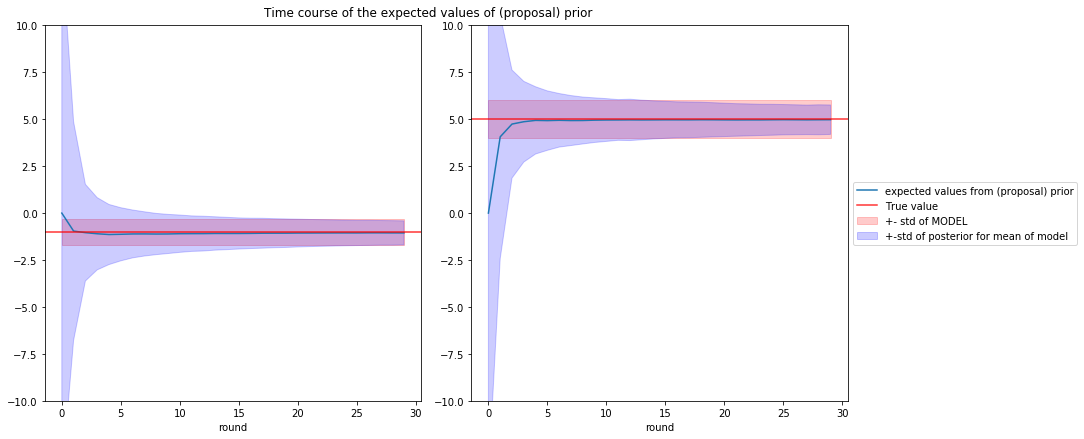

In [302]:
plot_time_course(means, stds, true_mean, true_std=[0.5**0.5,1], ylimits=[[-10,10],[-10,10]] )

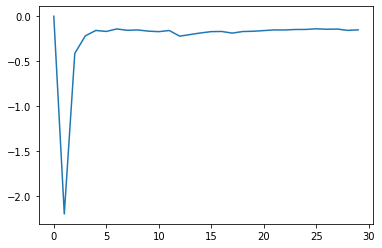

In [280]:
"""
plot covariances
"""
plt.plot(covs[:,0,1])

In [295]:
"""
evaluate model from mean of posterior
"""

predictions = np.zeros((50,2))

for i in range(50):
    predictions[i] = model(means[-1])

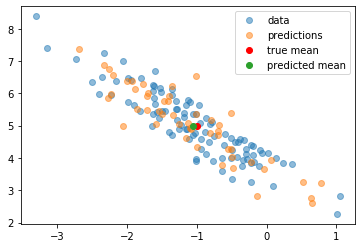

In [296]:
plt.plot(data[:,0],data[:,1],'o', label='data', alpha=0.5)
plt.plot(predictions[:,0],predictions[:,1],'o', label='predictions', alpha=0.5)

plt.plot(true_mean[0], true_mean[1],'o', color='r', label='true mean')
plt.plot(means[-1][0],means[-1][1], 'o', label='predicted mean')
plt.legend()